In [4]:
import rebound #do pip install rebound in a unix terminal, use ubuntu on windows.
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import pylab as pl
%matplotlib inline
sim = rebound.Simulation()

#integrator options
sim.integrator = "mercurius"
sim.dt = 0.025*2.*np.pi # in units where 1 year = 2*pi
sim.testparticle_type = 1
sim.ri_ias15.min_dt = 1e-6 
# ensure that close encounters do not stall the integration

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.track_energy_offset = 1

def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

6
mass of sun: 1.0
mass of Mars: 1.659e-07


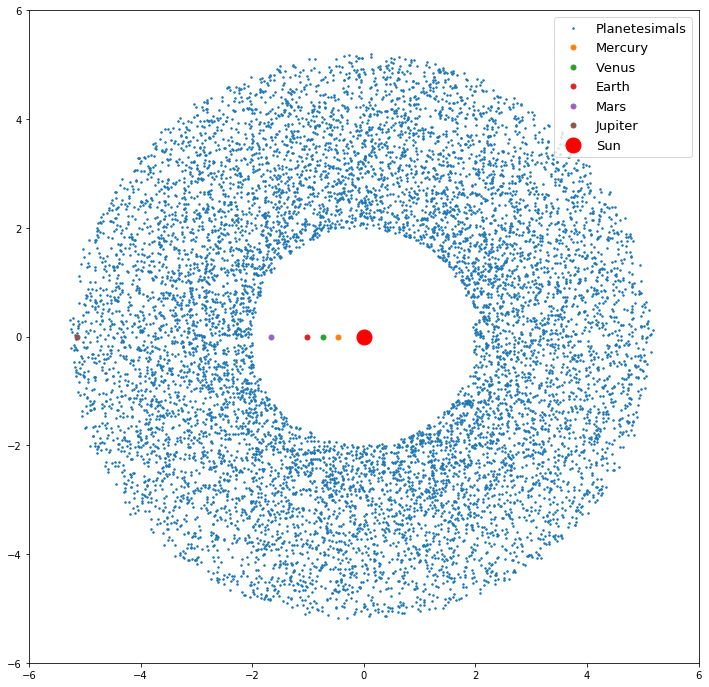

In [5]:
ceres_m = 0.00015*3e-6
vesta_m = 2.59076e-10
pallas_m = 2.11e-10
hygeia_m = 8.67e-11
total_ast = ceres_m + vesta_m + pallas_m + hygeia_m


sim.add(m=1.) #sun has mass set as 1, treated as a point mass
sim.add(m=0.0553*3e-6, a=0.39,e=0.206,f=np.pi) #Mercury
sim.add(m=0.814*3e-6, a=0.723,e=0.007,f=np.pi) #Venus with mass about 0.814 of earth's
sim.add(m=3e-6, a=1,e=0.017,f=np.pi) #Earth
sim.add(m=3e-7, a=1.524,e=0.093,f=np.pi)# Mars's mass is about 3e-7 that of Sun at 1.524 AU
sim.add(m=318*3e-6,r=2e-4, a=4.9 ,e=0.048,f=np.pi) #Jupiter mass is about 318 times of Earth's at 4.9 AU


sim.N_active = sim.N   # sim.N shows the total number of active particles in the simulation currently, which is 6

print(sim.N_active)
print 'mass of sun:',sim.particles[0].m
print 'mass of Mars:',sim.particles[1].m
N_pl = 10000                        # Number of planetesimals
M_moon = 0.114*sim.particles[1].m    # Mass of our moon is about 0.114 of Mars
Mtot_disk = total_ast*2              # Total mass of asteroid belt is about double of ceres + vesta + pallas +hygeia
m_pl = Mtot_disk / float(N_pl)       # Mass of each planetesimal
r_pl = 2e-5                          # Radius of each planetesimal

sim.move_to_com()

np.random.seed(42) # by setting a seed we will reproduce the same simulation every time
while sim.N < (N_pl + sim.N_active):
    a = rand_powerlaw(0, 2, 5.2) #asteroid belt reside between 2 to 4.5 AU
    e = rand_rayleigh(0.01)
    inc = rand_rayleigh(0.005)
    f = rand_uniform(-np.pi,np.pi)
    p = rebound.Particle(simulation=sim,primary=sim.particles[0],m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
    # Only add planetesimal if it's far away from the planet
    d = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
    if d>0.01:
        sim.add(p)
          
coords = np.zeros((2,sim.N))
sa = np.array([])

for i in range(5,sim.N):
    sa = np.append(sa,sim.particles[i].a)
    
for i in range(sim.N):
    coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    
plt.figure(figsize=(12,12))
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(coords[0],coords[1],'.',markersize=3)
plt.plot(sim.particles[1].x,sim.particles[1].y, '.',markersize=10); # Mercury
plt.plot(sim.particles[2].x,sim.particles[2].y, '.',markersize=10); # venus
plt.plot(sim.particles[3].x,sim.particles[3].y, '.',markersize=10); # earth
plt.plot(sim.particles[4].x,sim.particles[4].y, '.',markersize=10); # Mars
plt.plot(sim.particles[5].x,sim.particles[5].y, '.',markersize=10); # Jupiter
plt.plot(0,0,'r.',markersize=30)
plt.legend(['Planetesimals','Mercury','Venus','Earth','Mars','Jupiter','Sun'],loc=1,fontsize=13)
plt.show()

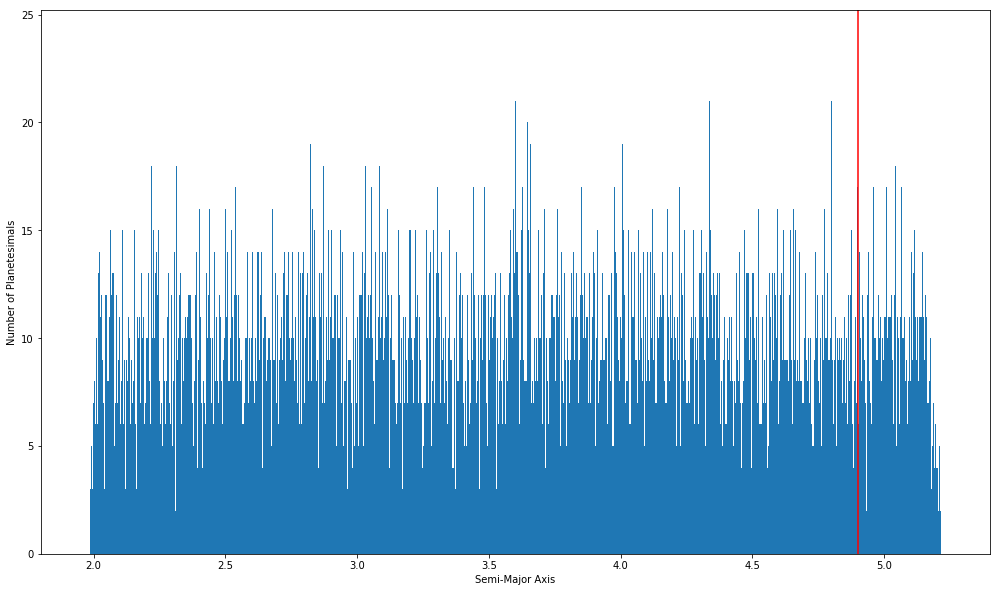

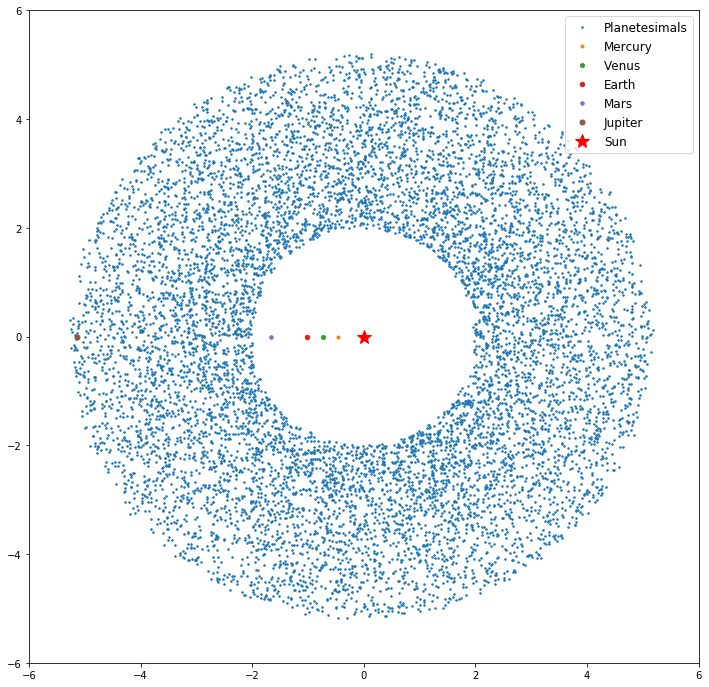

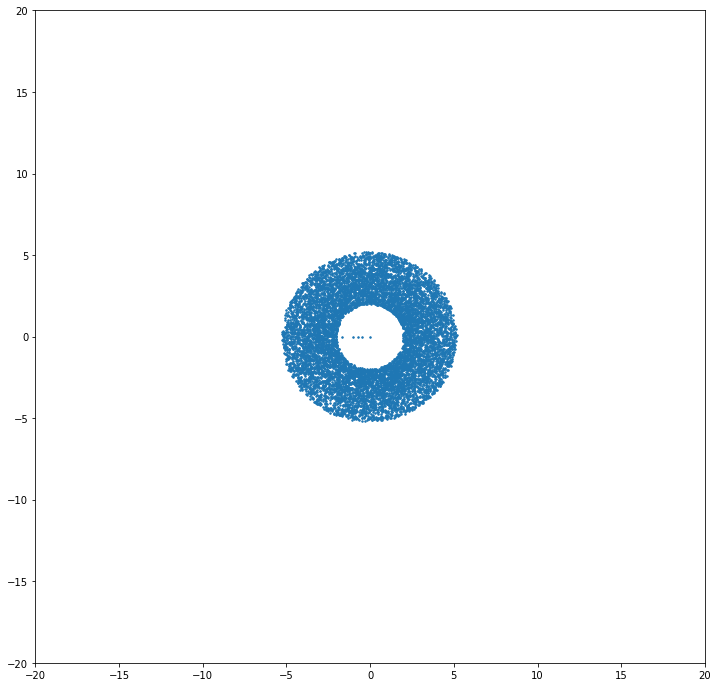

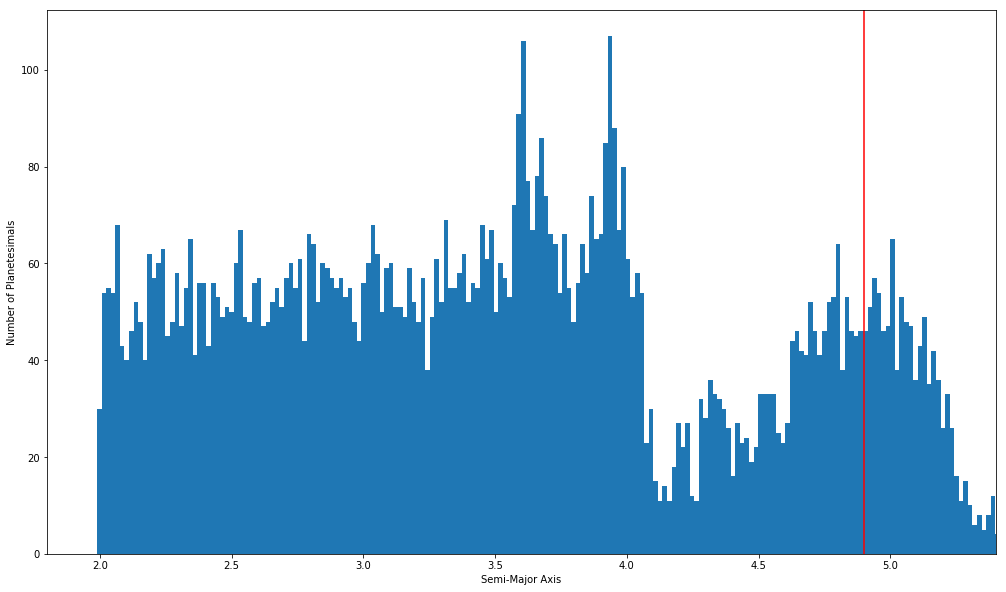

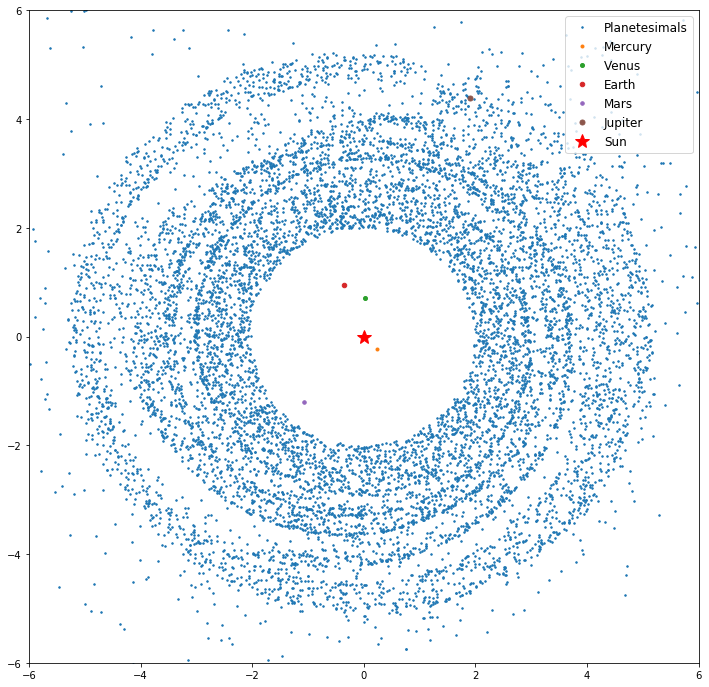

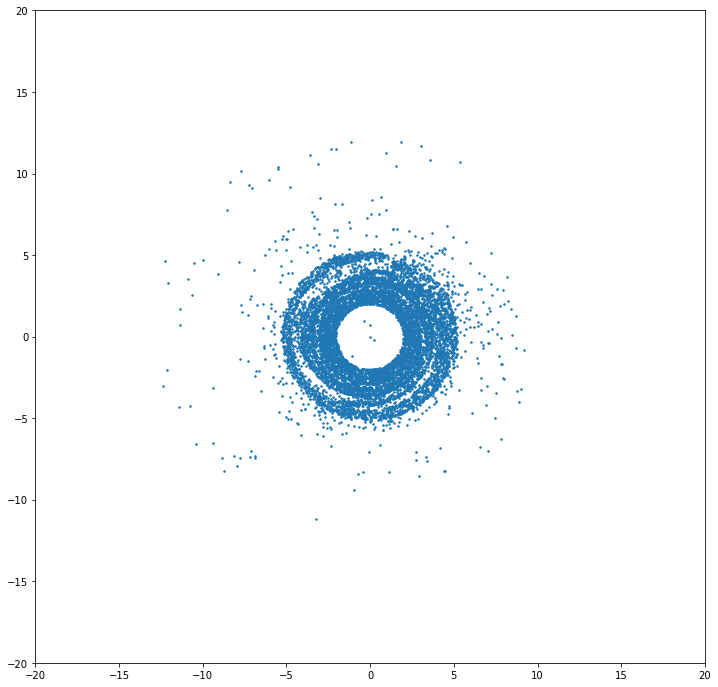

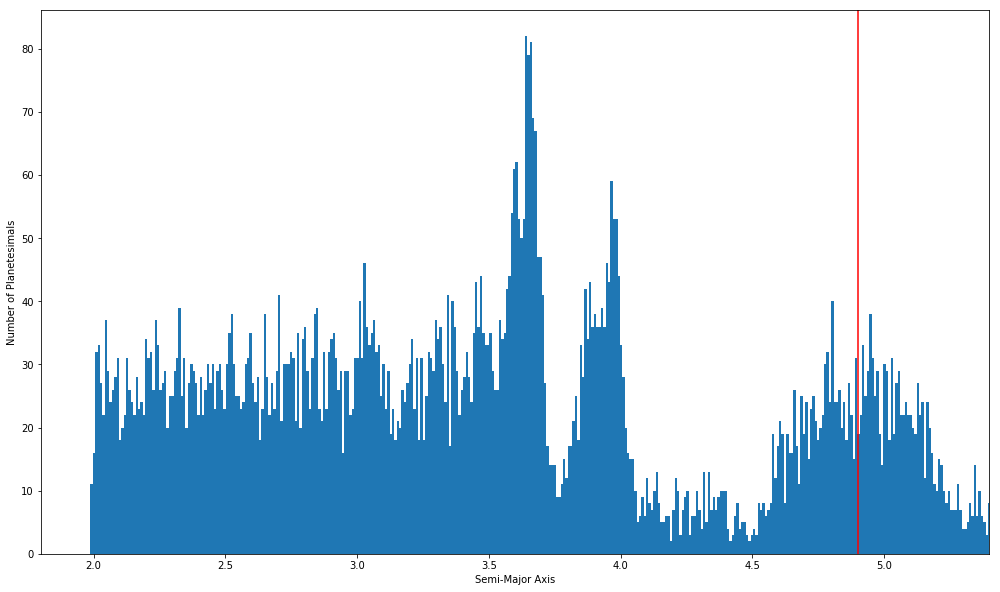

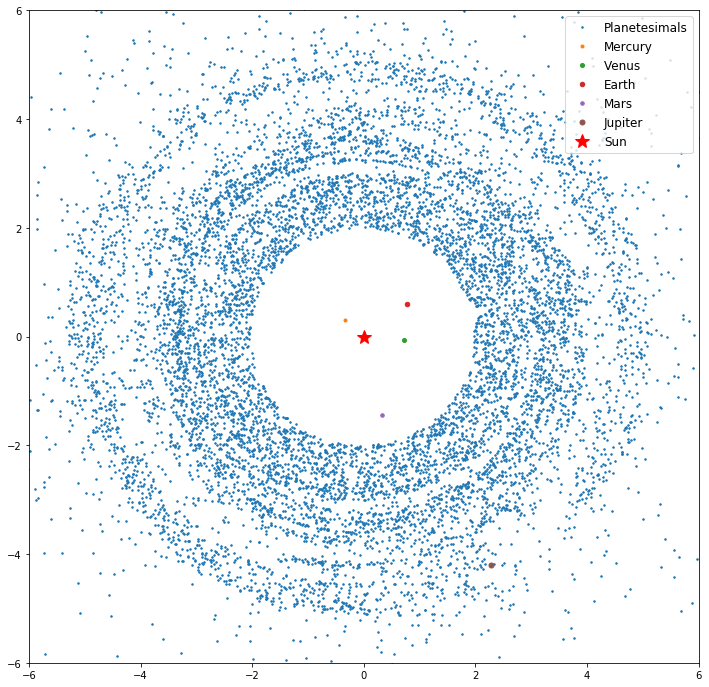

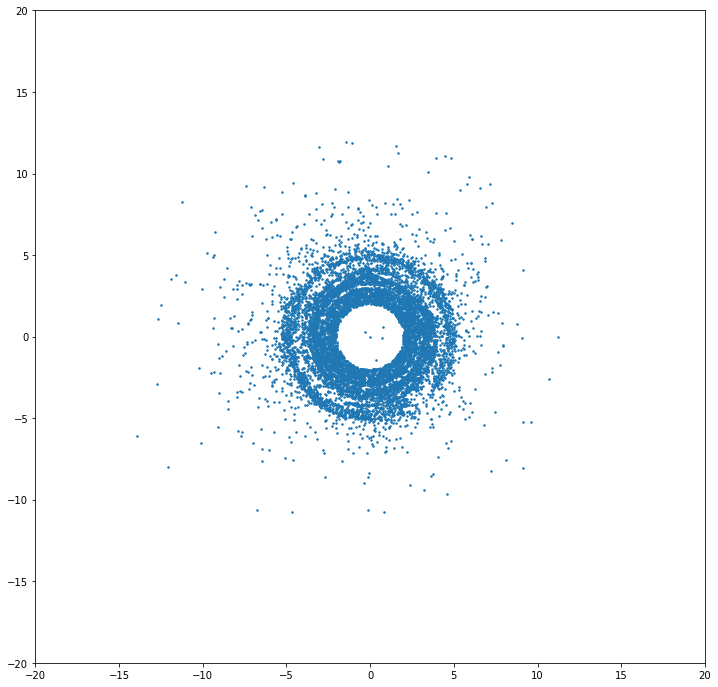

In [6]:
years = 500. #total elapsed time 500 is about~ 80 earth orbits
steps = 3   #steps in between total elapsed time, should be 1800 but use 3 to see quick result 
times = np.linspace(0.,years,steps)

for i, t in enumerate(times):
    print(sim.N)
    sim.integrate(t,exact_finish_time=0)
    coords = np.zeros((2,sim.N))
    
    for k in range(sim.N):
        coords[0][k], coords[1][k] = sim.particles[k].x, sim.particles[k].y
        
        
    #----------------------------------HISTOGRAM ---------------------------------------
    
    sa = np.array([])
    for j in range(5,sim.N):
        sa = np.append(sa,sim.particles[j].a)
        
    plt.figure(figsize=(17,10))
    plt.hist(sa,bins=1000)
    plt.xlabel('Semi-Major Axis')
    plt.ylabel('Number of Planetesimals')
    plt.xlim(1.8,5.4)
    plt.axvline(x=4.9,color='r')
    display.display(plt.gcf())
    #plt.savefig('histogram/' + str(i)+'.png')
    display.clear_output(wait=True)
    
    #---------------------------------Default Plot -------------------------------------
    
    plt.figure(figsize=(12,12))
    plt.xlim(-6,6)
    plt.ylim(-6,6)
    plt.plot(coords[0],coords[1],'.',markersize=3)
    plt.plot(sim.particles[1].x,sim.particles[1].y, '.',markersize=6); # Mercury
    plt.plot(sim.particles[2].x,sim.particles[2].y, '.',markersize=8); # venus
    plt.plot(sim.particles[3].x,sim.particles[3].y, '.',markersize=9); # earth
    plt.plot(sim.particles[4].x,sim.particles[4].y, '.',markersize=7); # Mars
    plt.plot(sim.particles[5].x,sim.particles[5].y, '.',markersize=10); # Jupiter
    plt.plot(0,0,'r*',markersize=15)
    plt.legend(['Planetesimals','Mercury','Venus','Earth','Mars','Jupiter','Sun'],loc=1,fontsize=12)
    
    display.display(plt.gcf())
   # plt.savefig('images/' + str(i)+'.png')
    display.clear_output(wait=True)
    
    #----------------------------------Blow Out Plot --------------------------------------
 
    plt.figure(figsize=(12,12))
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.plot(coords[0],coords[1],'.',markersize=3)
    display.display(plt.gcf())
   # plt.savefig('blow_out/' + str(i)+'.png')
    display.clear_output(wait=True)

In [7]:
#To create a movie from a folder containing N.png images,
#type this in the terminal, -r decides the fps
#ffmpeg -r 25 -i %01d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p -y <filename>.mp4